In [1]:
%load_ext autoreload
%autoreload 2

from models import Detr
from utils import load_config
import torch

torch.cuda.empty_cache()

config = load_config(r"configs\train.yaml")

model = Detr(
    train_mode=True,
    with_gcn=True,
    pretrained='facebook/detr-resnet-50',
    checkpoint="checkpoints\encoder-pretraining-2\loss=0.65.ckpt",
    config=config,
    lr=1e-4)

device = torch.device('cuda:0')
model.to(device)

<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
C:\Users\tangy\AppData\Local\Temp\ipykernel_22624\2372691923.py:16: SyntaxWarning: invalid escape sequence '\e'
  checkpoint="checkpoints\encoder-pretraining-2\loss=0.65.ckpt",


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

logger = WandbLogger(project='parallel_tables', name='e2e_attempt_2')

# Set up checkpointing and trainer
checkpoint_callback = ModelCheckpoint(
    monitor="validation/loss",
    filename="detr-{epoch:02d}-{validation/loss:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
    dirpath=r"C:\Users\tangy\Downloads\DETR-GFTE\checkpoints"
)

trainer = Trainer(
    max_epochs=50,
    log_every_n_steps=20,
    logger=None,
    callbacks=[checkpoint_callback],
    val_check_interval=0.3,  # Run validation 2 times per epoch
    devices=1,
    accelerator="gpu",
    gradient_clip_val=0.1,
    accumulate_grad_batches=8
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [85]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                   | Params | Mode 
--------------------------------------------------------------------
0 | model            | DetrForObjectDetection | 41.5 M | eval 
1 | simplified_tbnet | SimplifiedTbNet        | 263 K  | train
2 | gcn_criterion    | NLLLoss                | 0      | train
3 | bbox_encoder     | BBoxEncoder            | 33.7 K | train
--------------------------------------------------------------------
297 K     Trainable params
41.5 M    Non-trainable params
41.8 M    Total params
167.196   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [79]:
torch.save(model.state_dict(), 'test.pth')

pred_bboxes: [[8.220409393310547, 240.16688537597656, 9.705221176147461, 10.60528564453125], [221.33749389648438, 85.42630004882812, 20.155166625976562, 10.747772216796875], [4.969128131866455, 296.5960388183594, 77.31825256347656, 10.41400146484375], [221.778564453125, 71.88664245605469, 17.50457763671875, 10.154212951660156], [221.42018127441406, 239.1053466796875, 17.916275024414062, 10.888458251953125], [221.06082153320312, 169.17779541015625, 17.666885375976562, 10.703521728515625], [7.496551990509033, 170.78701782226562, 50.71630096435547, 11.1954345703125], [0.7856517434120178, 14.462630271911621, 44.08927536010742, 11.08155345916748], [338.7057800292969, 326.4298400878906, 39.93780517578125, 10.89630126953125], [458.464599609375, 296.4773254394531, 18.7093505859375, 10.235443115234375], [221.11038208007812, 365.8001708984375, 18.978836059570312, 10.3946533203125], [7.622995853424072, 29.43917465209961, 13.741762161254883, 10.92449951171875], [339.10113525390625, 43.680255889892

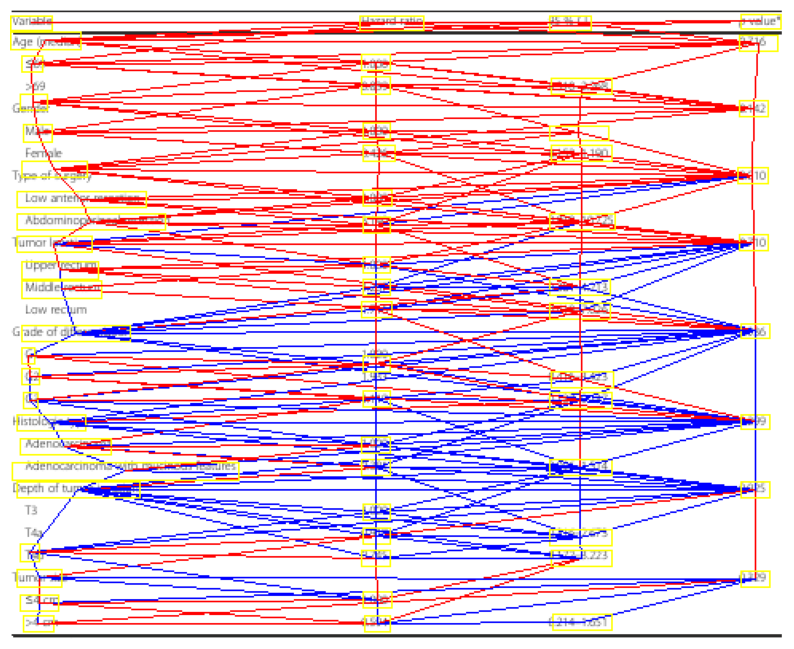

In [80]:


import cv2
from utils import draw_bboxes_and_edges
import matplotlib.pyplot as plt

image = cv2.imread('datasets/unified_train/PMC4840965_004_00.png')

with torch.no_grad():

    probs, bbox_pairs = model(image)

probs = torch.unsqueeze(probs, dim=0)
bbox_pairs = torch.unsqueeze(bbox_pairs, dim=0)

output_image = draw_bboxes_and_edges(image=image,prob_tensor=probs, edge_tensor=bbox_pairs, bbox_thickness=1, line_thickness=1)

# Convert BGR (OpenCV format) to RGB for displaying with matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the image in the notebook
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.axis('off')  # Hide axes
plt.show()

as you can seee in the above, the model is incentivized to only get as much vertical links as possible while ignoring horizontal links
let's build a thresholded, coordinate-encoded model first, then try to overfit on the single datapoint again

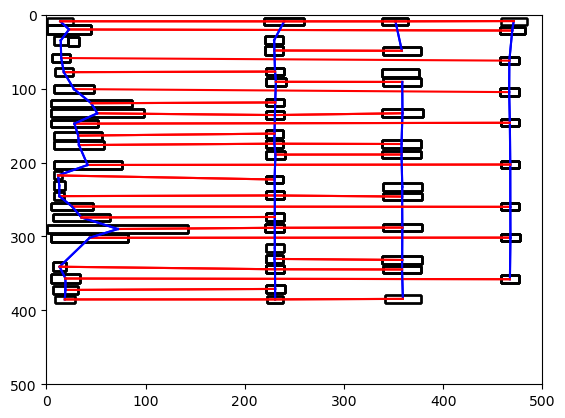

In [86]:
bbox_pairs = [[8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938, 7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812], [221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688, 339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812], [221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281, 339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688, 339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438], [221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688, 7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188], [221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188, 7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188], [7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188, 7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875], [7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719, 7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281], [22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 458.2099914550781, 3.961099624633789, 25.854705810546875, 9.35838794708252], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 0.9451406002044678, 4.22642183303833, 26.046833038330078, 9.385465621948242], [0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727, 219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258], [338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375, 338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375], [338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375], [458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125, 6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125], [221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125, 8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375], [221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125, 4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375], [221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125, 222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375], [221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281, 7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281], [7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469, 339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469], [339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469, 338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539], [339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469, 219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258], [338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375, 339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438], [339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125, 340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375], [339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125, 222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375], [339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 458.2099914550781, 3.961099624633789, 25.854705810546875, 9.35838794708252], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 0.9451406002044678, 4.22642183303833, 26.046833038330078, 9.385465621948242], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547, 219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375, 339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562], [338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438, 338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375], [338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438, 339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812], [456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688, 339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562], [4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688, 458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375], [4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125, 6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125], [6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125, 8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375], [6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125, 4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375], [6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125, 222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375], [220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625, 4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625], [220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625, 338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375], [220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625, 1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125], [220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375, 6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125], [8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375, 8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375], [8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375, 222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 338.89129638671875, 282.7889099121094, 39.880615234375, 10.400238037109375], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375, 339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 458.6242980957031, 254.97970581054688, 18.1947021484375, 9.930267333984375], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375, 339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438], [4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969, 8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688, 338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375], [338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375, 4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625], [6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375, 4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375], [6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031, 339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469], [337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031, 339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562], [221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625, 7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625], [7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625, 7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375], [7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 458.38616943359375, 197.8241729736328, 18.52093505859375, 9.79583740234375], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375], [7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375, 7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625], [7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375, 7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875], [7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375, 7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375], [7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938, 219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258], [1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125, 4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625], [1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125, 1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125], [1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [458.2099914550781, 3.961099624633789, 25.854705810546875, 9.35838794708252, 457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547], [458.2099914550781, 3.961099624633789, 25.854705810546875, 9.35838794708252, 458.2099914550781, 3.961099624633789, 25.854705810546875, 9.35838794708252], [458.2099914550781, 3.961099624633789, 25.854705810546875, 9.35838794708252, 338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539], [338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539, 339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469], [338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539, 457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547], [338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539, 458.2099914550781, 3.961099624633789, 25.854705810546875, 9.35838794708252], [338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539, 338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539], [338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539, 219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258], [0.9451406002044678, 4.22642183303833, 26.046833038330078, 9.385465621948242, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [0.9451406002044678, 4.22642183303833, 26.046833038330078, 9.385465621948242, 0.9451406002044678, 4.22642183303833, 26.046833038330078, 9.385465621948242], [0.9451406002044678, 4.22642183303833, 26.046833038330078, 9.385465621948242, 219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258], [6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375, 1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125], [6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719, 4.725034236907959, 114.79133605957031, 81.16744232177734, 10.091850280761719], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 457.1773376464844, 16.180923461914062, 24.920745849609375, 10.555126190185547], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 456.9448547363281, 99.72346496582031, 19.225738525390625, 10.047286987304688], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812], [457.3663024902344, 57.129215240478516, 18.729705810546875, 10.10262680053711, 339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562], [220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375, 4.367105484008789, 254.4279022216797, 43.127716064453125, 10.217941284179688], [220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375, 220.79872131347656, 282.8357238769531, 18.9580078125, 10.920074462890625], [220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375, 1.0958685874938965, 284.4101257324219, 142.10916137695312, 11.085235595703125], [220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375, 6.659246921539307, 269.32220458984375, 57.558738708496094, 10.04730224609375], [220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375, 220.96124267578125, 268.3003845214844, 18.573150634765625, 10.7366943359375], [221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125, 7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188], [7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375, 6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125], [4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375, 4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375], [4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375, 458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375], [4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312, 339.0979919433594, 43.677001953125, 38.575408935546875, 10.335197448730469], [220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016, 7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281], [6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016, 220.6709747314453, 42.88427734375, 18.336334228515625, 11.134597778320312], [6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016, 8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 4.962212085723877, 296.6109619140625, 77.33100891113281, 10.417633056640625], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 458.4670104980469, 296.4921569824219, 18.704437255859375, 10.2412109375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 221.36050415039062, 310.10406494140625, 17.907806396484375, 10.661956787109375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375], [458.26947021484375, 352.7734375, 18.087066650390625, 10.179779052734375, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438, 7.500089645385742, 170.79969787597656, 50.7022705078125, 11.200729370117188], [221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258, 22.31528663635254, 30.60745620727539, 10.982442855834961, 12.311576843261719], [219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258, 0.7853131890296936, 14.45013427734375, 44.14017105102539, 11.100732803344727], [219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258, 7.631430149078369, 29.444225311279297, 13.742977142333984, 10.940132141113281], [219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258, 220.50550842285156, 28.822853088378906, 18.407623291015625, 10.792953491210938], [219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258, 338.8622741699219, 4.225890636444092, 26.132781982421875, 9.636819839477539], [219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258, 0.9451406002044678, 4.22642183303833, 26.046833038330078, 9.385465621948242], [219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258, 219.7318572998047, 4.261911869049072, 40.08616638183594, 9.556795120239258], [4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875, 338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375], [4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875, 457.9357604980469, 141.2159881591797, 18.62628173828125, 10.0511474609375], [4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875, 4.660957336425781, 128.1454620361328, 93.32229614257812, 10.639236450195312], [4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875, 7.899670600891113, 158.10540771484375, 48.38768768310547, 11.03546142578125], [4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875, 221.02139282226562, 155.40606689453125, 17.970962524414062, 10.973251342773438], [4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875, 4.642564296722412, 142.26177978515625, 47.33305740356445, 10.30029296875], [340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375, 340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375], [340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375, 222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375], [340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375, 6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125], [222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375, 8.708475112915039, 380.18914794921875, 19.84663200378418, 10.054046630859375], [222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375, 340.91796875, 379.2791748046875, 37.03778076171875, 10.400238037109375], [222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375, 222.39781188964844, 380.1729431152344, 16.341903686523438, 10.00146484375], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 8.218263626098633, 240.17770385742188, 9.705015182495117, 10.610824584960938], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 7.52488899230957, 225.67523193359375, 11.004390716552734, 10.833648681640625], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 7.284043788909912, 198.12844848632812, 68.63214874267578, 10.39178466796875], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 7.559384346008301, 212.02264404296875, 8.541001319885254, 10.91839599609375], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125, 339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438], [220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812, 221.05819702148438, 169.1795654296875, 17.669692993164062, 10.716964721679688], [220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812, 338.8149108886719, 169.87831115722656, 38.45550537109375, 10.178146362304688], [220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 338.70458984375, 326.3669738769531, 39.94110107421875, 10.88519287109375], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 221.11190795898438, 365.817138671875, 18.986129760742188, 10.3985595703125], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 339.40924072265625, 339.666259765625, 38.275909423828125, 10.08477783203125], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 6.736877918243408, 367.33538818359375, 24.921688079833984, 10.1593017578125], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 6.9175896644592285, 335.2298583984375, 12.90494155883789, 11.485198974609375], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 221.15447998046875, 325.0892028808594, 17.715530395507812, 10.610443115234375], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 4.925456523895264, 351.10369873046875, 28.683738708496094, 11.62786865234375], [221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125, 221.00051879882812, 339.1810607910156, 18.981338500976562, 10.459259033203125], [8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812, 7.381278038024902, 95.18988037109375, 40.91530990600586, 10.949577331542969], [8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812, 6.062841415405273, 53.26499557495117, 17.84653663635254, 10.745548248291016], [8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812, 8.567371368408203, 72.23186492919922, 18.15862274169922, 11.100540161132812], [339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438, 221.41883850097656, 239.11427307128906, 17.9161376953125, 10.893722534179688], [339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438, 338.71832275390625, 184.06715393066406, 38.629730224609375, 10.21771240234375], [339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438, 338.8697204589844, 240.9014129638672, 39.56292724609375, 10.344833374023438], [339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438, 221.0784454345703, 217.69960021972656, 17.940628051757812, 10.49786376953125], [339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438, 220.94676208496094, 183.82061767578125, 19.976348876953125, 10.959426879882812], [339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438, 339.1907653808594, 227.80035400390625, 39.203582763671875, 10.072372436523438], [339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562, 221.3362579345703, 85.42396545410156, 20.159317016601562, 10.754318237304688], [339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562, 221.77755737304688, 71.89044189453125, 17.502838134765625, 10.162544250488281], [339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562, 338.259033203125, 128.1523895263672, 41.444488525390625, 10.409271240234375], [339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562, 221.51864624023438, 130.58261108398438, 17.827713012695312, 10.43798828125], [339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562, 337.9518737792969, 74.08226013183594, 38.018829345703125, 10.051887512207031], [339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562, 221.64500427246094, 113.52215576171875, 18.022125244140625, 10.409530639648438], [339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562, 339.3781433105469, 85.95746612548828, 38.764312744140625, 10.049209594726562]]

gt = [1, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2,
         1, 0, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1,
         1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0,
         0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0,
         0, 2, 2, 0, 2, 1, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0,
         2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0,
         0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0,
         0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 1, 0,
         2, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 2, 0, 0, 1,
         0, 2, 2, 1, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 0, 2, 1,
         0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2,
         0, 2, 2, 1, 1, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 0, 0, 1, 1, 0,
         1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
         0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2, 1, 1, 2,
         0, 0, 2, 2, 1, 1, 0, 2, 0, 1, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 2, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1,
         1, 0, 1, 2, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0,
         1, 1, 2, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 2,
         2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1]
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bboxes_with_edges(bbox_pairs, gt):
    """
    Plot the bounding boxes and their edges based on the `gt` values.
    
    Args:
        bbox_pairs (list of lists): Each inner list has 8 items, 
                                    representing two concatenated bounding boxes.
        gt (list): List of ground truth values (0, 1, or 2) corresponding to each edge.
                   0 = Transparent edge, 1 = Red edge, 2 = Blue edge.
    """
    fig, ax = plt.subplots(1)

    for i, bbox_pair in enumerate(bbox_pairs):
        # Extract the two bounding boxes
        bbox1 = bbox_pair[:4]
        bbox2 = bbox_pair[4:]

        # Plot bbox1
        rect1 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2], bbox1[3], linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect1)
        
        # Plot bbox2
        rect2 = patches.Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3], linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect2)

        # Extract center points for bbox1 and bbox2 to draw edges
        center1 = (bbox1[0] + bbox1[2] / 2, bbox1[1] + bbox1[3] / 2)
        center2 = (bbox2[0] + bbox2[2] / 2, bbox2[1] + bbox2[3] / 2)

        # Determine the edge color based on the gt value
        if gt[i] == 0:
            edge_color = (0, 0, 0, 0)  # Transparent
        elif gt[i] == 1:
            edge_color = 'red'
        elif gt[i] == 2:
            edge_color = 'blue'
        else:
            edge_color = 'black'  # Fallback color for unexpected gt values

        # Plot the edge between the centers of the two bounding boxes
        ax.plot([center1[0], center2[0]], [center1[1], center2[1]], color=edge_color)

    # Set limits and show the plot
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 500)
    plt.gca().invert_yaxis()  # Optional: Invert Y axis if needed (depends on your coordinate system)
    plt.show()

# Test the function
plot_bboxes_with_edges(bbox_pairs, gt)


In [84]:
probs_2 = torch.squeeze(probs, dim=0)
probs_2 = probs_2.tolist()
for inner_list in probs_2:
    print(inner_list.index(max(inner_list)))


1
0
2
2
1
1
1
1
1
0
1
1
2
2
2
2
2
2
2
2
2
2
2
1
1
0
1
2
1
1
1
1
1
2
1
1
1
1
2
2
1
0
1
2
1
2
1
0
1
2
1
1
0
1
1
1
0
1
1
0
1
2
2
2
2
2
2
2
2
2
2
0
2
2
0
2
2
2
2
2
2
0
1
1
0
2
1
0
2
2
2
0
1
1
1
1
1
0
1
1
1
0
1
0
1
1
1
1
1
1
2
1
2
2
0
1
2
2
2
1
2
2
2
2
2
1
1
1
1
1
0
1
0
1
0
0
1
1
2
1
1
1
1
1
1
2
1
1
2
2
1
0
0
1
1
1
1
1
2
1
1
1
1
1
2
1
1
2
2
1
1
2
1
2
0
2
2
2
2
1
2
2
2
0
1
2
0
2
2
0
2
0
2
1
1
1
0
1
1
0
2
1
2
1
1
2
1
2
2
2
0
2
2
2
2
0
1
2
1
2
1
2
2
2
2
1
2
0
0
1
0
2
2
1
2
1
2
2
2
2
1
2
1
2
0
2
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
1
0
1
1
2
2
1
1
1
1
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
2
0
1
1
1
2
2
2
2
1
2
1
2
1
2
1
1
1
1
1
0
1
0
2
0
2
2
2
0
1
1
0
1
0
1
1
0
1
0
1
0
2
0
2
2
2
1
1
1
1
1
0
0
1
1
1
1
1
1
0
1
1
1
1
1
0
2
2
2
2
1
1
1
2
2
2
1
2
2
0
2
1
2
1
2
0
1
2
2
2
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
2
1
0
0
0
2
2
2
2
0
2
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
2
1
0
0
1
2
0
2
1
1
2
2
1
2
1
1
1
2
1
1
1
1
1
1
2
1
1
2
1
2
0
1
2
0
2
1
0
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
